In [ ]:
!pip install opencv-python numpy matplotlib scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/plantvillage2/"

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
data_dir = "/content/drive/MyDrive/plantvillage2/"
image_size = (128, 128)
X, Y = [], []

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, image_size)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            features = img_gray.flatten()  # Convert image to 1D feature vector
            X.append(features)
            Y.append(class_name)

X = np.array(X)
Y = np.array(Y)


In [ ]:
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, Y_train)


SVC(kernel='linear')

Accuracy: 74.32%
                                                    precision    recall  f1-score   support

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.45      0.36      0.40       103
                       Corn_(maize)___Common_rust_       0.98      1.00      0.99       243
               Corn_(maize)___Northern_Leaf_Blight       0.61      0.58      0.59       206
                            Corn_(maize)___healthy       0.71      0.80      0.75       219

                                          accuracy                           0.74       771
                                         macro avg       0.69      0.68      0.68       771
                                      weighted avg       0.73      0.74      0.74       771



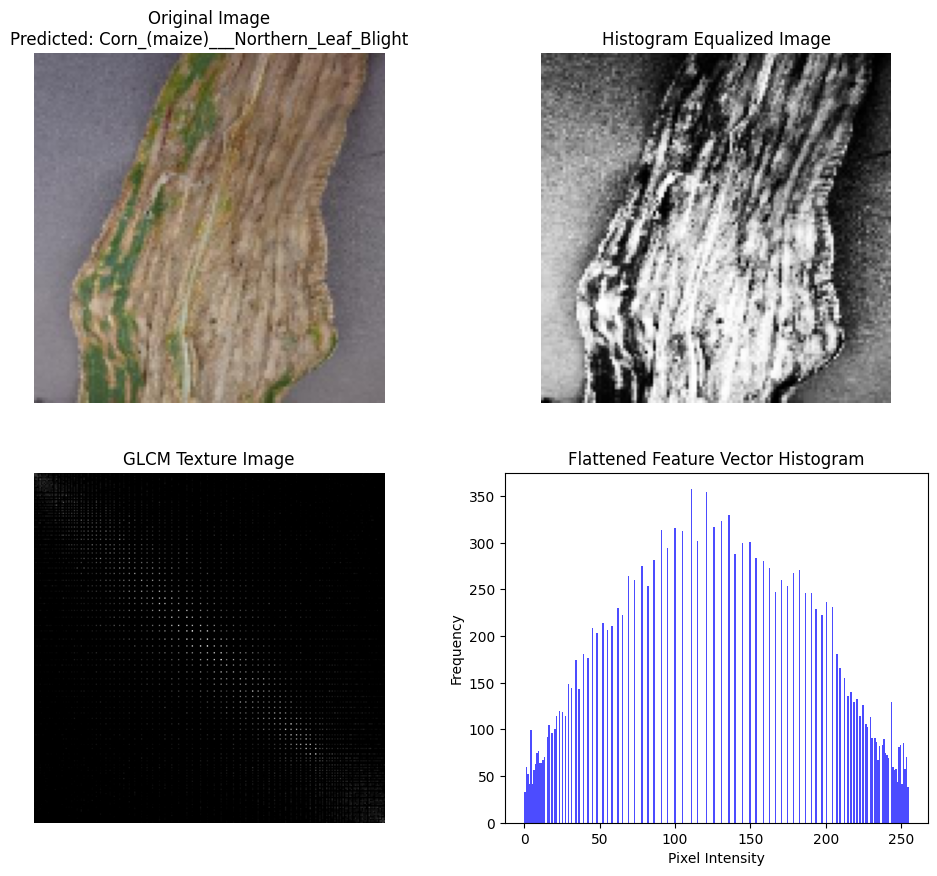

In [ ]:
import skimage.feature

def extract_glcm_features(img_gray):
    # Compute GLCM (Gray Level Co-occurrence Matrix)
    glcm = skimage.feature.graycomatrix(img_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    # Extract contrast feature
    contrast = skimage.feature.graycoprops(glcm, 'contrast')[0, 0]

    return glcm[:, :, 0, 0], contrast  # Return GLCM matrix for visualization and contrast value

def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, image_size)  # Resize to match training images
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Apply Histogram Equalization
    img_hist_eq = cv2.equalizeHist(img_gray)

    # Extract GLCM features from histogram-equalized image
    glcm_matrix, contrast = extract_glcm_features(img_hist_eq)

    # Convert image into 1D feature vector
    features = img_hist_eq.flatten()

    # Apply normalization before prediction
    features_scaled = scaler.transform(features.reshape(1, -1))

    # Predict the class
    prediction = svm_model.predict(features_scaled)
    class_name = label_encoder.inverse_transform([prediction[0]])[0]  # Convert label number to class name

    # Display Original, Histogram Equalized, GLCM, and Feature Histogram
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Original Image
    axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title(f"Original Image\nPredicted: {class_name}")
    axes[0, 0].axis("off")

    # Histogram Equalized Image
    axes[0, 1].imshow(img_hist_eq, cmap="gray")
    axes[0, 1].set_title("Histogram Equalized Image")
    axes[0, 1].axis("off")

    # GLCM Image
    axes[1, 0].imshow(glcm_matrix, cmap="gray")
    axes[1, 0].set_title("GLCM Texture Image")
    axes[1, 0].axis("off")

    # Feature Vector Histogram
    axes[1, 1].hist(features, bins=256, color='blue', alpha=0.7)
    axes[1, 1].set_title("Flattened Feature Vector Histogram")
    axes[1, 1].set_xlabel("Pixel Intensity")
    axes[1, 1].set_ylabel("Frequency")

    plt.show()

# Test with an image
predict_image("/content/drive/MyDrive/CornBlight.JPG")  # Change to your test image path
